<a href="https://colab.research.google.com/github/milkyfranky/catcancode/blob/main/Copy_of_BTL_MM_EX_1_19_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALLING NEEDED PACKAGES

In [ ]:
%pip install gurobipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 69.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

# FIRST STAGE PROBLEM

$n = 8$: number of products <br>
$m = 5$: number of parts to be orered before production <br>
$i$: index of products, $i \, = \, 1, \ ..., \ n$ <br>
$j$: index of parts, $j \, = \, 1, \ ..., \ m$ <br>
$c_j$: ordering cost of a part <br>
$l_i$: additional cost to satisfy a unit of demand for product $i$ <br>
$q_i$: unit selling price of a product <br>
$s_j$: salvage value of a part ($s_j < c_j$ ) <br>
$a_{i,j}$: a units of product $i$ requires this number of part $j$, maybe 0 <br>
$x_j$: number of parts for pre-order <br>
$z_i$: number of units produced <br>
$y_j$: number of parts left in inventory <br>
$D = (D_1, \, ..., \, D_n)$: random vector of demand for the products <br>
$d = (d_1, \, ..., \, d_n)$: observed value of demand for the products <br>
<br>
**FIRST STAGE PROBLEM**<br>
\begin{equation}
\sum_{x \geq 0} c^{T}x \, + \,  \text{E} [Q(x, \, D)]
\end{equation}

**SECOND STAGE PROBLEM**<br>
\begin{equation}
\text{Min}_{z,y} \sum_{i=1}^{n} (l_i - q_i) z_i - \sum_{j=1}^{m} s_j y_j
\end{equation}

$\underline{Constraints}$
\begin{equation}
y_j = x_j - \sum_{j=1}^{m} a_{ij} z_i
\end{equation}
\begin{equation}
0 \leq z_i \leq d_i
\end{equation}
\begin{equation}
y_j \geq 0
\end{equation}
\begin{equation}
x \geq 0
\end{equation}

**ONE LARGE SCALE LINEAR PROGRAMMING**<br>
When finitely many demand scenarios $d^1, \, ..., \, d^K$ occuring with positive probabilities $p_1, \, ..., \, p_K$, with $\sum_{k = 1}^{K} \, p_k = 1$, we will have this one large scale linear programming problem as follow:
\begin{equation}
\text{Min} \, \, c^{T}x + \, \sum_{k = 1}^{K} \, p_k \, \, [(l - q)^T z^k - s^T y^k]
\end{equation}

$\underline{Constraints}$
\begin{equation}
y^k = x - A^T z^k
\end{equation}
\begin{equation}
0 \leq z^k \leq d^k
\end{equation}
\begin{equation}
y^k \geq 0
\end{equation}
\begin{equation}
x \geq 0
\end{equation}


Let $\text{E} [Q(x, \, d)]$ denote the optimal value of problem. <br>
The Expectation is taken with respect to the probability distribution of the random demand vector D. <br>
The first part of the objective function represents the *ordering cost*. <br>
The second part represents the *expected cost of the optimal production plan*. <br>


## Stimulate the data

Table of probability:
         prob
scen 1   0.5
scen 2   0.5
Table of demand:
         scen 1  scen 2
prod 1      76      70
prod 2      99      72
prod 3      59      83
prod 4      88      82
prod 5      74      62
prod 6      87      92
prod 7      61      53
prod 8      66      89
Table of pre cost parts:
         pre-cost-part
part 1             18
part 2             12
part 3             13
part 4             17
part 5             18
Table of additional products cost:
         add-cost-prod
prod 1            221
prod 2            190
prod 3            175
prod 4            144
prod 5            135
prod 6            242
prod 7            249
prod 8            169
Table of unit selling price of products:
         unit selling price
prod 1                1344
prod 2                 642
prod 3                1123
prod 4                1282
prod 5                1359
prod 6                1457
prod 7                 619
prod 8                1444
Table of salvage value of parts:
   

<Axes: >

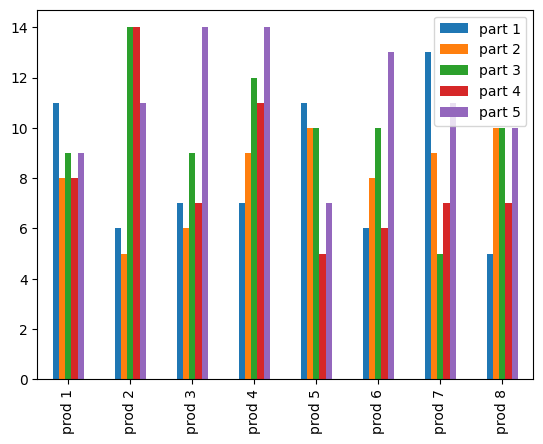

In [ ]:
n = 8
m = 5
S = 2
np.random.seed(69)
product_list = []
part_list = []
scenario_list = []
for i in range(S):
    nameScene = "scen " + str(i+1)
    scenario_list.append(nameScene)

for i in range(n):
    nameProd = "prod " + str(i + 1)
    product_list.append(nameProd)

for i in range(m):
    namePart = "part " + str(i + 1)
    part_list.append(namePart)

product_list = np.array(product_list)
part_list = np.array(part_list)

# c, l, q, s -> take simulated data.
# ---------------------------------------------------------
# PROBABILITY
prob = np.random.binomial(10, 1/2, (S)) # create S random demand, value from 1 -> 10
prob = prob / sum(prob) # divide by sum to get the probability based on the binomial distribution
prob = np.array([0.5, 0.5])

dict_prob = {"prob": prob}
probTable = pd.DataFrame(dict_prob, index=scenario_list)
print("Table of probability:\n", probTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# DEMAND
rng = np.random.default_rng()
demand = np.random.randint(50, 100, size=(n,S))

dict_demand = dict.fromkeys(scenario_list)
for i in range(S):
    dict_demand[scenario_list[i]] = demand[:,i]
demandTable = pd.DataFrame(dict_demand, index=product_list)
print("Table of demand:\n", demandTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# PRE-ORDERING NUMBER OF PARTS
# c: pre-ordering cost of parts, cost for ordering in the first stage
pre_cost_part = np.random.randint(10, 20, size=m)

dict_pre_cost = {"pre-cost-part": pre_cost_part}
pre_cost_partTable = pd.DataFrame(dict_pre_cost, index=part_list)
print("Table of pre cost parts:\n", pre_cost_partTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# ADDITIONAL COST FOR PRODUCTS
# l: additional cost to satisfy a unit
additional_cost_prod = np.random.randint(100, 250, size=n)

dict_add_cost = {"add-cost-prod": additional_cost_prod}
add_cost_prodTable = pd.DataFrame(dict_add_cost, index=product_list)
print("Table of additional products cost:\n", add_cost_prodTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# UNIT SELLING PRICE FOR PRODUCTS
# q: unit selling price
price_prod = np.random.randint(500, 1500, size=n)

dict_unit_sell_price = {"unit selling price": price_prod}
unit_sell_price_prodTable = pd.DataFrame(dict_unit_sell_price, index=product_list)
print("Table of unit selling price of products:\n", unit_sell_price_prodTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# SALVAGE VALUES FOR PARTS
# s: salvage values => this must be less than the ordering cost (s < c)
salvage_val_part = np.random.randint(0, pre_cost_part, size=m)

dict_salvage = {"salvage value parts": salvage_val_part}
salvage_val_partTable = pd.DataFrame(dict_salvage, index=part_list)
print("Table of salvage value of parts:\n", salvage_val_partTable)
# ---------------------------------------------------------
# ---------------------------------------------------------
# MATRIX PRODUCTS REQUIREMENT
# Matrix A: element a_{i,j} means that product i requires aij units of part j
# This element must be in Z+
A_prod_part = rng.integers(5, 15, size=(n, m))

dict_prod_require_part = dict.fromkeys(part_list)
for i in range(len(part_list)):
    dict_prod_require_part[part_list[i]] = A_prod_part[:,i]
prod_require_partTable = pd.DataFrame(dict_prod_require_part, index=product_list)
print("Table of products requirement from parts:\n", prod_require_partTable)
# ---------------------------------------------------------
prod_require_partTable.plot.bar()

In [ ]:
# np.random.seed(0)
# df2 = pd.DataFrame(np.random.randn(10,4), columns=['A','B','C','D'])
# df2

## Define first stage model, its constraints and objective function

In [ ]:
# DEFINE THE FIRST STAGE MODEL
model_first = gp.Model("First_stage_model")
model_first.ModelSense = 1 # minimize problem (if maximize, this value is -1)
model_first.setParam('OutputFlag', 0)  # Telling gurobi to not be verbose
#model_first.params.logtoconsole=0

Restricted license - for non-production use only - expires 2024-10-28


In [ ]:
# CONSTRAINTS
# Add decision variable, type MVar
# addMVar ( shape, lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name="" )
# You can use arithmetic operations with MVar objects to create linear matrix expressions
# or quadratic matrix expressions, then be used to build linear or quadratic objectives or constraints.

# First stage decision variable
x_first = model_first.addMVar((m,), vtype = GRB.INTEGER, name = "x_first")

# 2nd stage decision variables for each potential scenario
y_first = model_first.addMVar((m,S), vtype = GRB.INTEGER, name = "y_first")
z_first = model_first.addMVar((n,S), vtype = GRB.INTEGER, name = "z_first")
# By default, the lower bound is 0

# ADDING CONSTRAINTS
model_first.addConstr(0 <= z_first)
model_first.addConstr(0 <= y_first)
model_first.addConstr(z_first <= demand)
model_first.addConstrs(
    y_first[:, k] == x_first - A_prod_part.T @ z_first[:, k] for k in range(S)
)

objective = pre_cost_part @ x_first + gp.quicksum(
                gp.quicksum(
                    (additional_cost_prod[i] - price_prod[i]) * z_first[i, k] for i in range(n)) -
                    gp.quicksum(salvage_val_part[j] * y_first[j, k] for j in range(m)
                ) * prob[k] for k in range(S)
            )
model_first.setObjective(objective)

## First stage solving

In [ ]:
# SOLVING
model_first.optimize()
print("The optimal value at the first stage is:", -model_first.ObjVal)
print("The number of pre-ordering parts:", x_first.x)

The optimal value at the first stage is: 757673.5
The number of pre-ordering parts: [4905. 4885. 6227. 5149. 6835.]


In [ ]:
print(x_first.x)
print(y_first.x)
print(z_first.x)

[4905. 4885. 6227. 5149. 6835.]
[[  0. 180.]
 [  0.   6.]
 [  0. 163.]
 [  0. 242.]
 [ 35.   0.]]
[[76. 70.]
 [99. 72.]
 [59. 83.]
 [88. 82.]
 [74. 62.]
 [87. 92.]
 [60. 53.]
 [66. 89.]]


# SECOND STAGE PROBLEM

## Define second stage model, its observing demand, the constraints and objective value

In [ ]:
# NOW CONSIDER THE SECOND STAGE PROBLEM
# ASSUME THAT HERE IS THE OBSERVED DEMAND
observed_demand = np.random.randint(50, 100, size=n)
print("Observed demand:", observed_demand)

# Store the pre-ordering number of parts from stage 1
store_x = x_first.x

model_second = gp.Model("second_stage_model")
model_second.ModelSense = 1 # minimize problem (if maximize, this value is -1)
model_second.setParam('OutputFlag', 0)  # Telling gurobi to not be verbose

y_second = model_second.addMVar((m,), vtype = GRB.INTEGER, name = "y_second")
z_second = model_second.addMVar((n,), vtype = GRB.INTEGER, name = "z_second")
# By default, the lower bound is 0

# ADDING CONSTRAINTS
model_second.addConstr(0 <= z_second)
model_second.addConstr(0 <= y_second)
model_second.addConstr(z_second <= observed_demand.T)
model_second.addConstr(
    y_second[:] == store_x.T - A_prod_part.T @ z_second[:]
)

objective_second = gp.quicksum((additional_cost_prod[i] - price_prod[i]) * z_second[i] for i in range(n)) - gp.quicksum(salvage_val_part[j] * y_second[j] for j in range(m))
model_second.setObjective(objective_second)

Observed demand: [64 99 68 87 94 74 64 79]


## Second stage solving

In [ ]:
# SOLVING
model_second.optimize()
print("The optimal value at the second stage is:", -model_second.ObjVal)
print("The number of parts left in the inventory:", y_second.x)
print("The number of units products produced:", z_second.x)

The optimal value at the second stage is: 608281.0
The number of parts left in the inventory: [1243.  860. 1525. 1737. 1679.]
The number of units products produced: [64. -0. 68. 87. 94. 74. -0. 79.]
